In [1]:
import pandas as pd
import pathlib
import tensorflow as tf
import os
import shutil
import livelossplot 
from sklearn.metrics import log_loss

In [2]:
pd.set_option('display.max_rows',None)

train_path='C:/Users/gimaevra94/Documents/local/competition/train.csv'
test_path='C:/Users/gimaevra94/Documents/local/competition/test.csv'

train_data=pd.read_csv(train_path,dtype=str)
test_data=pd.read_csv(test_path,dtype=str)

In [3]:
# в train_data много строк без указания типа данных
# в correct_names все строки с указанием типа данных
# по этому я возьму строки из correct_names
# и заменю ими строки из train_data

correct_names=pd.read_csv(os.getcwd()+'\\correct_names.txt')
correct_names=pd.Series(correct_names.items())

#там изначально полные пути. достаю только имена
correct_names=[name[60:] for name in correct_names[0][1]]

# если имя без указания типа данных из correct_names
# совпадает с именем без указания типа данных из train_data
# то уже полное имя из из correct_names correct_names 
# заменяет полное имя из train_data
for name in correct_names:
    for _,row in train_data.iterrows():
        if name[:10] == row['id']:
            row['id']=name
            
for name in correct_names:
    for _,row in test_data.iterrows():
        if name[:10] == row['id']:
            row['id']=name

In [4]:
# имена изображений разделены на два файла
# но сами изображения лежат в общей папке
# теперь, исходя из исправленных имен в train_data и test_data
# я разделю изображения по папкам

# папки для разделения
os.makedirs('C:/Users/gimaevra94/Documents/local/competition/test/test_')
os.makedirs('C:/Users/gimaevra94/Documents/local/competition/train')

os.makedirs('C:/Users/gimaevra94/Documents/local/competition/train/0')
os.makedirs('C:/Users/gimaevra94/Documents/local/competition/train/1')

# путь где лежат несортированные изображения
imgs_path='C:/Users/gimaevra94/Documents/local/competition/images/'

# сорировка по папкам исходя из имен в train_data и test_data
for _, row in train_data.iterrows():
    label=row['target']
    img_old_path=imgs_path+row['id']
    img_new_path=os.path.join('C:/Users/gimaevra94/Documents/local/competition/train/'+label,row['id'])
    shutil.copy(img_old_path,img_new_path)

for _, row in test_data.iterrows():
    img_old_path=imgs_path+row['id']
    img_new_path=os.path.join('C:/Users/gimaevra94/Documents/local/competition/test/test_',row['id'])
    shutil.copy(img_old_path,img_new_path)

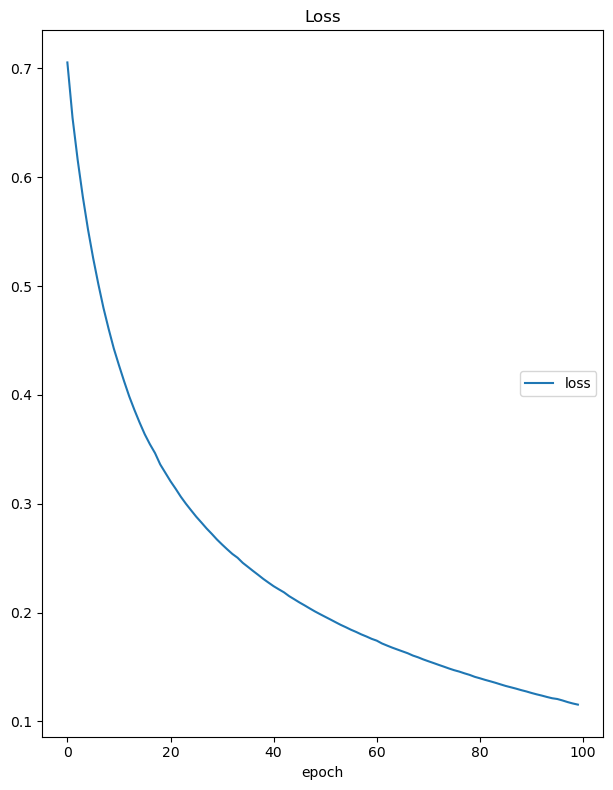

Loss
	loss             	 (min:    0.116, max:    0.706, cur:    0.116)
32/32 [==============================] - 9s 284ms/step - loss: 0.1155


In [5]:
# дериктории для генераторов
base_dir=pathlib.Path().parent/'C:/Users/gimaevra94/Documents/local/competition/'
train_dir=base_dir/'train'
test_dir=base_dir/'test'

fl_dir=train_dir/'0'
tr_dir=train_dir/'1'

val_dir=test_dir/'test_'

# легкая сеть предобученная на имеджнете 
preprocess_input_=tf.keras.applications.mobilenet_v2.preprocess_input

# препроцессинг от этой сети
train_gen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input_)
test_gen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input_)

# генераторы
train=train_gen.flow_from_directory(target_size=(96,96),
                                   color_mode='rgb',
                                   class_mode='binary',
                                   directory=train_dir)

test=test_gen.flow_from_directory(target_size=(96,96),
                                   color_mode='rgb',
                                   class_mode='binary',
                                   directory=test_dir,
                                    shuffle=False)

# веса imagenet т.к. сеть обучалась именно на нем
base_model=tf.keras.applications.MobileNetV2(input_shape=(96,96,3),
                                       include_top=False,
                                       weights='imagenet')

# обучение всей сети выключено 
# потому что обучаться будет
# только 1 дополнительный слой
base_model.trainable=False

# подсмотрел в одном видео что этот слой неплохой вариант
# само собой сигмоида
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# оптимайзер выбрал дефолтный
# ошибка само собой бинарная кроссэнтропия
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy')

# добавил коллбек чтобы смотреть 
# как ведет себя ошибка в реальном времени
history=model.fit(x=train,
                    epochs=100,
                    batch_size=64,
                    callbacks=[livelossplot.PlotLossesKeras()])

In [6]:
# предсказания
preds=model.predict(test)


preds2=list()

# убираю лишнее в переменной с предсказаниями
for pred in preds:
    value=str(pred[0])
    value2=value.replace(',', '.')
    preds2.append(round(float(value2),1))
    
preds=preds2.copy()

# теперь предсказания нужно склеить
# со строками для которых они делались

# беру имена из генератора
test_names=[name[6:] for name in test.filenames]

# порядок имен и предсказаний в генераторе един
# по этому просто склеиваю их в пандасе
result=pd.DataFrame({'id':test_names,'target':preds})


for_sort=list()

# кагл требует порядок предсказаний как в test_data
# беру истинный порядок из test_data
# и для каждой строки из test_data 
# прохожусь по строкам result пока не найду совпадения
# таким образом в итоговый файл строки будут попадать
# в порядке из test_data
for _,row in test_data.iterrows():
    for _2,row2 in result.iterrows():
        if row[0][:10] == row2[0][:10]:
            for_sort.append(row2)
            
# итоговый файл который едет в сабмит
result=pd.DataFrame(for_sort).reset_index()
result.drop(columns=['index'],inplace=True)

16/16 [==============================] - 7s 341ms/step
